# Image analysis of colony growth 

In [1]:
# For numerical computation
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For cool interactive stuff
import panel as pn

# For image analysis
import skimage.io

# To find files
import glob

# This enables high resolution graphics inline
%config InlineBackend.figure_format = 'retina'
sns.set()
pn.extension()

## Find files and read example file into memory

In [2]:
# Define directory where images exist
datadir = '../data/ecoli_growth/'

# List TRITC images
files = glob.glob(datadir + '*TRITC*.tif')
files[0:5]

['../data/ecoli_growth/ecoli_TRITC_18.tif',
 '../data/ecoli_growth/ecoli_TRITC_19.tif',
 '../data/ecoli_growth/ecoli_TRITC_09.tif',
 '../data/ecoli_growth/ecoli_TRITC_20.tif',
 '../data/ecoli_growth/ecoli_TRITC_08.tif']

Let's read one of the images into memory

In [3]:
# Read example image into memory
im = skimage.io.imread(files[0])

# Let's show an image
im

array([[206, 205, 206, ..., 203, 203, 205],
       [206, 204, 204, ..., 203, 203, 205],
       [205, 205, 205, ..., 203, 203, 204],
       ...,
       [205, 203, 204, ..., 205, 205, 205],
       [205, 205, 205, ..., 203, 204, 205],
       [205, 205, 205, ..., 204, 205, 206]], dtype=uint16)

Let's show the image

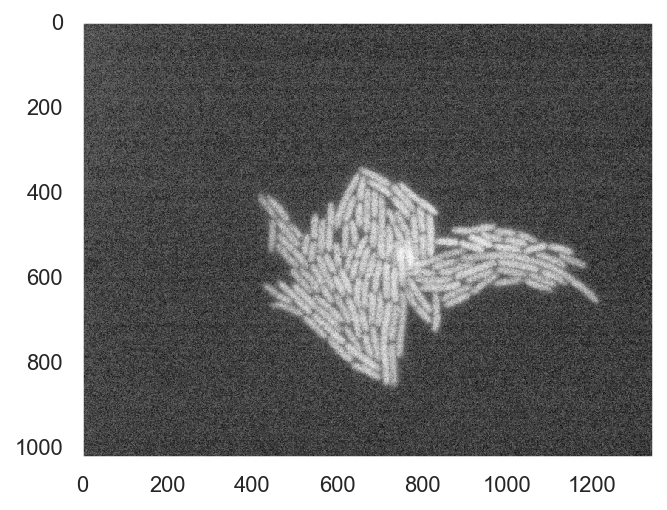

In [4]:
plt.imshow(im, cmap=plt.cm.Greys_r)

# Turn off seabrons grid
plt.grid(False)

Normalize our image to have values from 0 to 1.

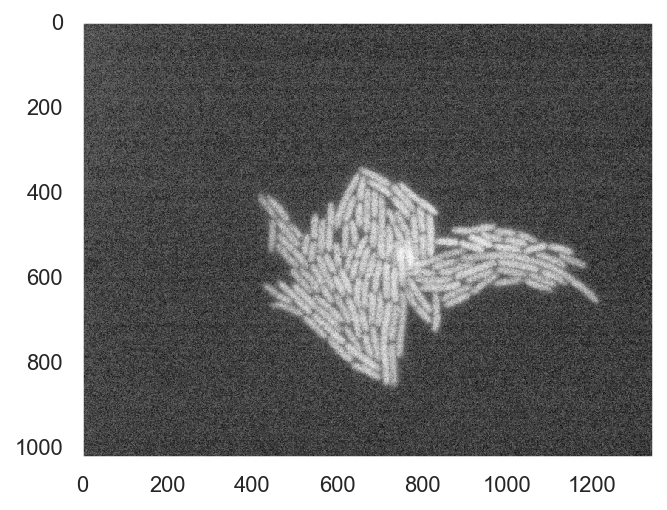

In [5]:
# Normalize image
im_float = (im - im.min()) / (im.max() - im.min())

# Display normalized image
plt.imshow(im_float, cmap=plt.cm.Greys_r)

plt.grid(False)

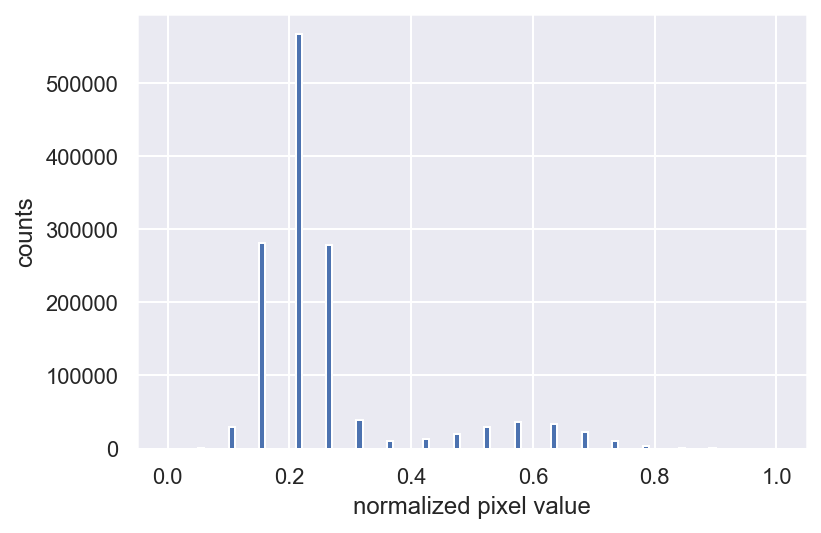

In [13]:
plt.hist(im_float.flatten(), bins=100)
plt.xlabel('normalized pixel value')
_ = plt.ylabel('counts')

Set threshold value for cells to be ≈ 0.4

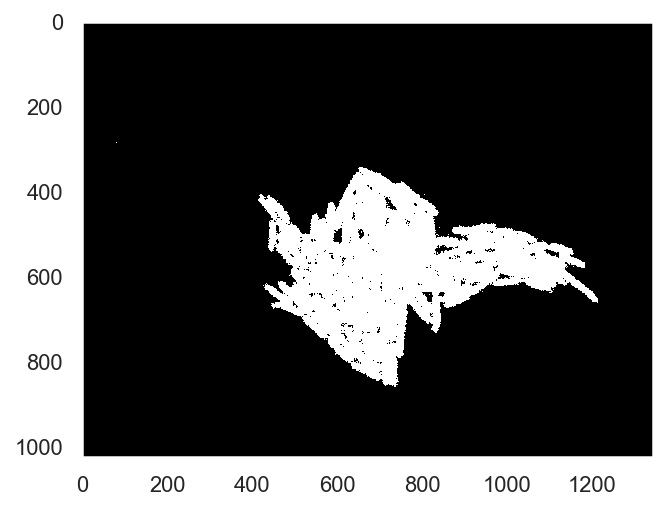

In [18]:
# Define threshold
thresh = 0.4

# Find pixels associated with cells
im_thresh = im_float > thresh

# Show segmented image
plt.imshow(im_thresh, cmap=plt.cm.Greys_r)
plt.grid(False)

Let's set this threshold to be an interactive slider

Column
    [0] FloatSlider(end=1, name='Threshold slider', start=0, step=0.01, value=0.4)
    [1] ParamFunction(function)
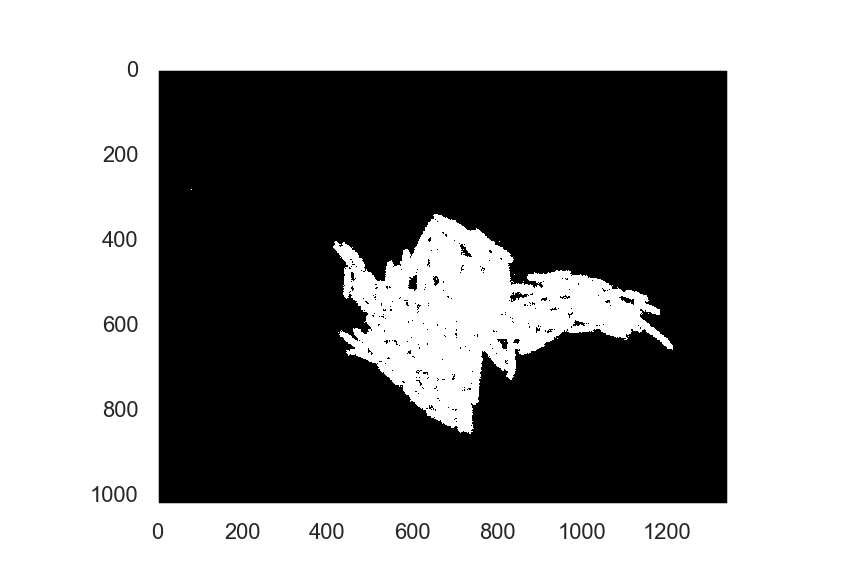

In [21]:
# Define slider using panel
thresh_slider = pn.widgets.FloatSlider(
    name='Threshold slider',
    start=0,
    end=1,
    step=0.01,
    value=0.4
)

# Define interactive plot
@pn.depends(thresh_slider.param.value)
def get_plot(thresh):
    fig, ax = plt.subplots(1, 1) # initialize empty plot
    ax.imshow(im_float > thresh,
               cmap = plt.cm.Greys_r)
    ax.grid(False)
    plt.close(fig)
    return fig

# Arrange interactive plot
pn.Column(
    thresh_slider,
    get_plot
)

In [22]:
np.sum(im_thresh)

170191

In [25]:
files = np.sort(files)
files

array(['../data/ecoli_growth/ecoli_TRITC_00.tif',
       '../data/ecoli_growth/ecoli_TRITC_01.tif',
       '../data/ecoli_growth/ecoli_TRITC_02.tif',
       '../data/ecoli_growth/ecoli_TRITC_03.tif',
       '../data/ecoli_growth/ecoli_TRITC_04.tif',
       '../data/ecoli_growth/ecoli_TRITC_05.tif',
       '../data/ecoli_growth/ecoli_TRITC_06.tif',
       '../data/ecoli_growth/ecoli_TRITC_07.tif',
       '../data/ecoli_growth/ecoli_TRITC_08.tif',
       '../data/ecoli_growth/ecoli_TRITC_09.tif',
       '../data/ecoli_growth/ecoli_TRITC_10.tif',
       '../data/ecoli_growth/ecoli_TRITC_11.tif',
       '../data/ecoli_growth/ecoli_TRITC_12.tif',
       '../data/ecoli_growth/ecoli_TRITC_13.tif',
       '../data/ecoli_growth/ecoli_TRITC_14.tif',
       '../data/ecoli_growth/ecoli_TRITC_15.tif',
       '../data/ecoli_growth/ecoli_TRITC_16.tif',
       '../data/ecoli_growth/ecoli_TRITC_17.tif',
       '../data/ecoli_growth/ecoli_TRITC_18.tif',
       '../data/ecoli_growth/ecoli_TRITC_19.tif',


In [36]:
# Initialize array to save areas
area_array = np.zeros(len(files))

for i, file in enumerate(files):
    # 1. Read file into memory
    im = skimage.io.imread(file)
    # 2. Nomalize image
    im_float = (im - im.min()) / (im.max() - im.min())
    # 3. Apply threshold
    im_thresh = im_float > thresh
    # 4. Save number of pixels occupied by cells
    area_array[i] = np.sum(im_thresh)

Now that we segmented the images let's plot the area over time

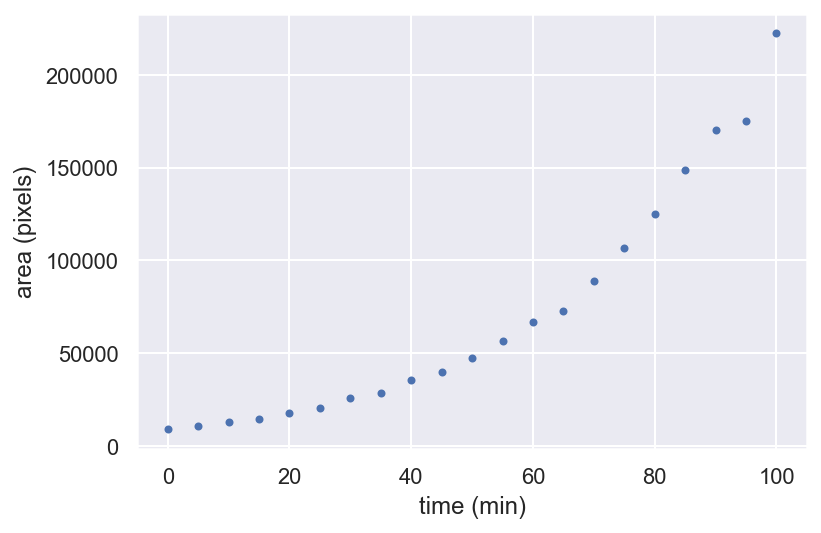

In [30]:
# Define time resolution of images
dt = 5  # min
# Define array for measurement times
time = np.arange(len(files)) * dt

# Plot time vs area
plt.plot(time, area_array, '.')

# Label our axis
plt.xlabel('time (min)')
_ = plt.ylabel('area (pixels)')

Plot growth curve on semilogy 

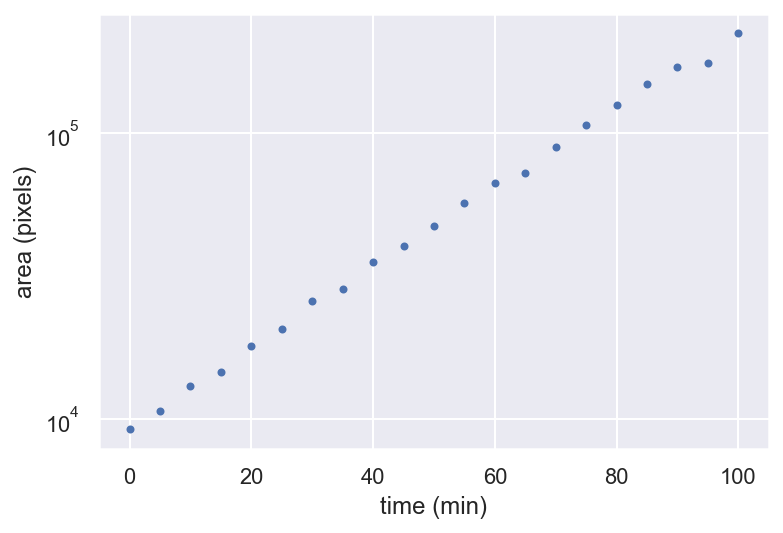

In [31]:
# Plot time vs area
plt.plot(time, area_array, '.')
# Change y axis to log scale
plt.yscale('log')
# Label our axis
plt.xlabel('time (min)')
_ = plt.ylabel('area (pixels)')

## Fitting an exponential function to the data

Column
    [0] FloatSlider(end=0.1, name='growth rate', start=0.01, step=0.001, value=0.03)
    [1] ParamFunction(function)
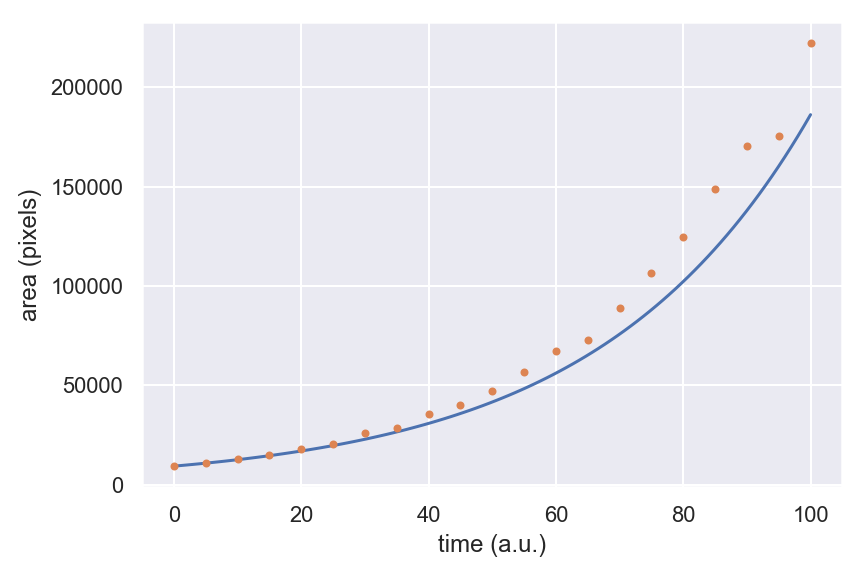

In [46]:
time_array = np.linspace(0, time.max(), 100)

k_slider = pn.widgets.FloatSlider(
    name='growth rate',
    start=0.01,
    end=0.1,
    step=0.001,
    value=0.03,
)

@pn.depends(k_slider.param.value)
def growth_plot(k):
    # Compute area
    area_theory = area_array[0] * np.exp(k * time_array)
    # Initialize figure
    fig, ax = plt.subplots(1, 1)
    # Plot theory
    ax.plot(time_array, area_theory)
    # Plot data
    ax.plot(time, area_array, '.')
    # Label plot
    ax.set_xlabel('time (a.u.)')
    ax.set_ylabel('area (pixels)')
    plt.tight_layout()
    plt.close(fig)
    return fig

pn.Column(
    k_slider,
    growth_plot
)

To compute the best fit to the data we need to minimize the sum of the square of the error between theory and data.

Let's define a function that for a given growth rate $k$ it computes the error.

In [32]:
def err(areas, times, growth_rate):
    '''
    Function that computes error between theory and experiment
    Parameters
    ----------
    areas : array-like.
        Experimental value of colony areas
    times : array-like.
        Time where measurements were taken
    growth_rate : float.
        Growth rate.
    
    Returns
    -------
    chi_squared : float.
        Sum of the square of the error between theory and data
    '''
    # Compute theoretical area
    area_theory = areas[0] * np.exp(growth_rate * times)
    
    # Compute chi_squared
    chi_squared = np.sum((area_theory - areas)**2)
    
    return chi_squared

Quick check that the function is working

In [48]:
# Define array of growth rates to evaluate
k_array = np.linspace(0, 0.1, 200)

# Initialize array to save the values of the chi_squared
chi_sqr = np.zeros(len(k_array))

# Loop through growth rates
for i, k in enumerate(k_array):
    # Compute and store chi squared
    chi_sqr[i] = err(area_array, time, k)

Plot error vs growth rate

Text(0, 0.5, 'error squared')

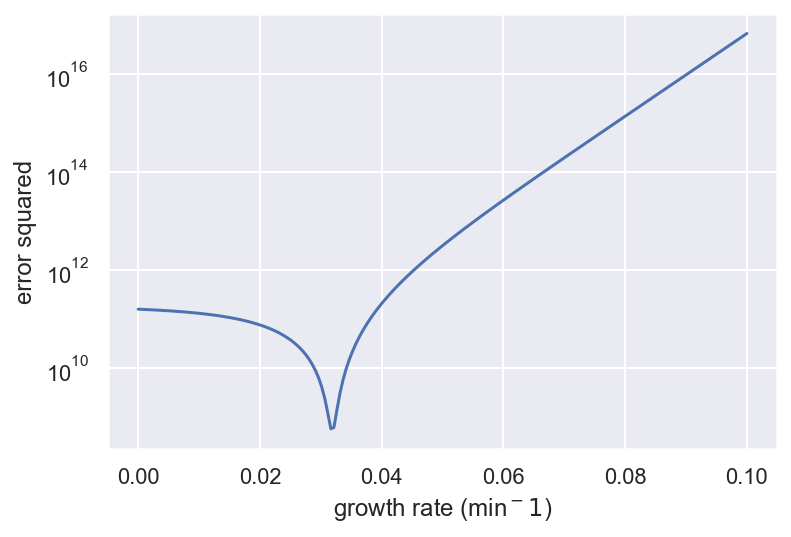

In [50]:
plt.plot(k_array, chi_sqr)
plt.yscale('log')
# Label axis
plt.xlabel('growth rate (min$^-1$)')
plt.ylabel('error squared')

Let's now find the growth rate corresponding to the minimum error

In [57]:
# find index of optimal growth rate
k_idx = np.where(chi_sqr == chi_sqr.min())[0]

# Extract value of optimal growth rate
k_opt = k_array[k_idx]

print(f'optimal growth rate: {np.round(k_opt, 2)} min**-1')

optimal growth rate: [0.03] min**-1


Plot theory vs. data

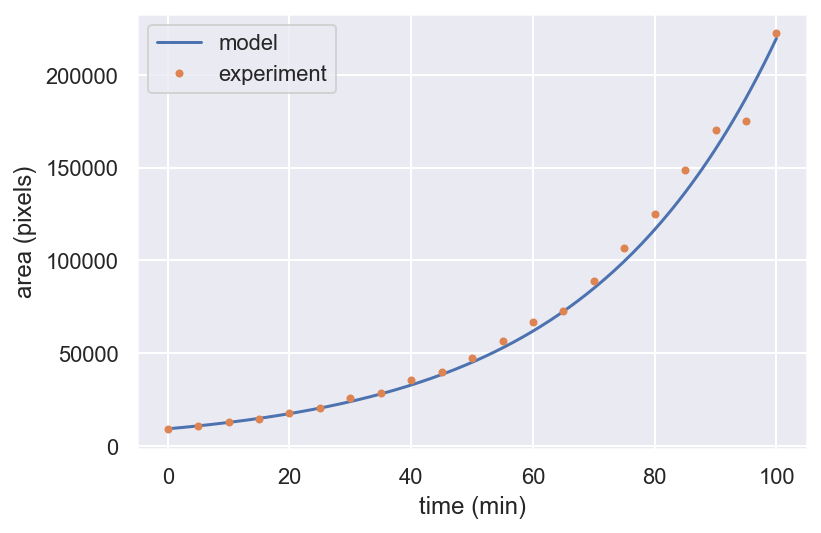

In [59]:
# Define time array for smooth plot
time_array = np.linspace(0, time.max(), 200)

# Evaluate model with optimal growth rate
area_model = area_array[0] * np.exp(k_opt * time_array)

# Plot theory
plt.plot(time_array, area_model, label='model')

# Plot data
plt.plot(time, area_array, '.', label='experiment')

# Label axis
plt.xlabel('time (min)')
plt.ylabel('area (pixels)')

_ = plt.legend()